In [3]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import pandas as pd
import bioread
from scipy.fftpack import fft, fftfreq,ifft
from scipy import signal
from scipy.signal import find_peaks

In [4]:
def FIRrespt(ninput,xinput,nh,h):
    Nx=len(xinput);Nh=len(h);conv=np.convolve(xinput,h);n0=ninput[0]+nh[0];Nconv=Nx+Nh-1;nconv=np.arange(n0,n0 + Nconv)
    R = np.vstack((nconv,conv)).T
    return R   

def FIRrespf(w,h):
    Nh=len(h); H = 0
    for i in np.arange(Nh):
        H = H + h[i]*np.exp(-1j*w*i)
    R = np.vstack((w,abs(H),np.angle(H))).T
    return R 

def IIRrespt(xinput,c,d):
    N1 = len(xinput) # 
    nx = np.arange(-(len(c)-1),N1)
    x = xinput
    for k in np.arange(len(c)-1):
        x = np.insert(x,0,0)
    ny = np.arange(-(len(d)-1),N1)
    y = np.arange(0,len(ny),dtype=np.float64)
    for k in np.arange(len(d)-1):
        y[k] = 0
    for i in np.arange(len(d)-1,len(y)):
        z = 0
        for j in np.arange(1,len(d)):
            z = z - d[j]*y[i-j] + c[j]*x[i-j]
        y[i] = (z + c[0]* x[i])/d[0]
    R = np.vstack((ny,y)).T
    return R

def IIRrespf(w,c,d):
    Nc=len(c); Nd=len(d); Hnum = 0; Hden = 0
    for i in np.arange(Nc):
        Hnum = Hnum + c[i]*np.exp(-1j*w*i)
    for i in np.arange(Nd):
        Hden = Hden + d[i]*np.exp(-1j*w*i)
    H = np.divide(Hnum,Hden)
    R = np.vstack((w,abs(H),np.angle(H))).T
    return R

In [5]:
def IIR(nombreArchivo):
    #...Ingreso Señal...
    
    ECG = bioread.read_file (nombreArchivo)
    canales = ECG.channels
    for i in np.arange (0,len(canales)):
        print (f"Canal {i}: {canales[i]}")

    canal_elegido = 0
    t = ECG.time_index.T

    señal = ECG.channels[canal_elegido].data

    N = len(señal)
    Fs = ECG.channels[canal_elegido].samples_per_second
    
    # Elimino tendencia -----------------------------------------------------------------------------
    A3 = np.arange(0,N,250) #arreglo
    B3 = tuple(A3) #tupla
    señal = signal.detrend(señal,bp=A3)
    #------------------------------------------------------------------------------------------------
    
    #...Obtengo espectro de señal

    espectro = fft(señal)/N
    w = np.linspace(0,2*np.pi,N)
    eje_f = w*Fs/(2*np.pi)
    
    #---Analizo el espectro entre los 40 y 65 Hz
    f_min = np.where(eje_f>40)
    f_max = np.where((eje_f>40)&(eje_f<65))
    
    f_m = f_min[0][0] #frecuencia mínima de analisis
    f_M = f_max[0][len(f_max[0])-1] #frecuencia máxima de análisis
    
    #...Determino cual es el valor de mi frecuencia de ruido...    
    vm = np.where(abs(espectro)[f_m:f_M]==np.max(abs(espectro)[f_m:f_M]))
    f_r = eje_f[f_m+vm[0][0]] #frecuencia de ruido
    
    i = 5;j = 2
    
    #...Determino los valores de frecuencias de paso y de rechazo
    
    fp1 = (f_r - i);    fp2 = (f_r + i)
    fr1 = (f_r - j);    fr2 = (f_r + j) 
    
    #...Valores de atenuacion de banda de paso y banda de rechazo 
    gpass = 1;     gstop = 20
    
    wp = np.array([fp1,fp2])/(Fs/2)
    wr = np.array([fr1,fr2])/(Fs/2)
    
    N3,wc3 = signal.buttord(wp, wr, gpass, gstop, False)
    
    b3, a3 = signal.butter(N3, wc3, 'bandstop')
    w3, h3 = signal.freqz(b3, a3)
    
    #...Filtrado de la señal  
    señal_filtrada = IIRrespt(señal,b3,a3)
    
    #Analisis de atenuacion: Saco los picos en señal original y señal filtrada
    peaks_max = find_peaks (señal,distance=500)[0]
    peaks_min = find_peaks (-señal,distance=500)[0]
    A_max_signal = np.mean(señal[peaks_max]) ; A_min_signal = np.mean(señal[peaks_min])

    peaks_max = find_peaks (señal_filtrada[:,1],distance=500)[0]
    peaks_min = find_peaks (-señal_filtrada[:,1],distance=500)[0]
    A_max = np.mean(señal_filtrada[:,1][peaks_max]) ; A_min = np.mean(señal_filtrada[:,1][peaks_min])
    
    A_signal = A_max_signal - A_min_signal ; A_signal_filtr = A_max - A_min

    Atenuac = np.round ((A_signal - A_signal_filtr)*100/A_signal,1)

    ### Ruido
    max_noise = max(señal_filtrada[:,1][400:600]) #ruido uniforme en toda la señal
    min_noise = min(señal_filtrada[:,1][400:600])

    A_noise = max_noise - min_noise
    SNR = A_signal_filtr / A_noise
    SNR_dB = 20*np.log (A_signal_filtr/A_noise)
      
    condicion = 1        
    
    while (condicion==1):
        
        i = i+1;     j = j+1    
        #amplío la ventana de filtrado
        fp1 = (f_r - i);        fp2 = (f_r + i)
        fr1 = (f_r - j);        fr2 = (f_r + j) 

        wp = np.array([fp1,fp2])/(Fs/2);        wr = np.array([fr1,fr2])/(Fs/2)

        N3_c,wc3 = signal.buttord(wp, wr, gpass, gstop, False)

        b3, a3 = signal.butter(N3_c, wc3, 'bandstop')
        w3, h3 = signal.freqz(b3, a3)
        
        #...Filtro
        señal_filtrada_c = IIRrespt(señal,b3,a3)
        
         #Analisis de atenuacion
    ### Saco los picos en señal original y señal filtrada
    
        peaks_max = find_peaks (señal_filtrada_c[:,1],distance=500)[0]
        peaks_min = find_peaks (-señal_filtrada_c[:,1],distance=500)[0]
        A_max = np.mean(señal_filtrada_c[:,1][peaks_max]) ; A_min = np.mean(señal_filtrada_c[:,1][peaks_min])
        
        A_signal = A_max_signal - A_min_signal ; A_signal_filtr = A_max - A_min


        Atenuac_c = np.round ((A_signal - A_signal_filtr)*100/A_signal,1)

        ### Ruido
        max_noise = max(señal_filtrada_c[:,1][400:600]) #ruido uniforme en toda la señal
        min_noise = min(señal_filtrada_c[:,1][400:600])

        A_noise = max_noise - min_noise
        SNR_c = A_signal_filtr / A_noise
        SNR_dB_c = 20*np.log (A_signal_filtr/A_noise)
       
        
        if SNR_c<SNR:
            condicion = 0
            #...Gráfico de señal
            plt.figure(figsize=(20,4),dpi=600)
            plt.plot(t,señal,label='ecg con interferencia')
            plt.plot(señal_filtrada[:,0]/Fs,señal_filtrada[:,1],label='ecg filtrada')
            plt.legend(fontsize=12)
            plt.title(('Filtro IIR de orden',N3,''));plt.xlabel('t seg')
            plt.grid (True)
            
            plt.show()
            print("ATENUACION:",Atenuac)
            print('SNR:',SNR)
            print('SNR(dB):',SNR_dB)
            
        else:
            #...Gráfico de señal      
            señal_filtrada = señal_filtrada_c
            SNR = SNR_c; SNR_dB = SNR_dB_c        
            N3 = N3_c
            condicion = 1      
    print('Filtrado finalizado')
        
        

Canal 0: Channel ECG (.05 - 150 Hz): 20167 samples, 1000.0 samples/sec, loaded: True


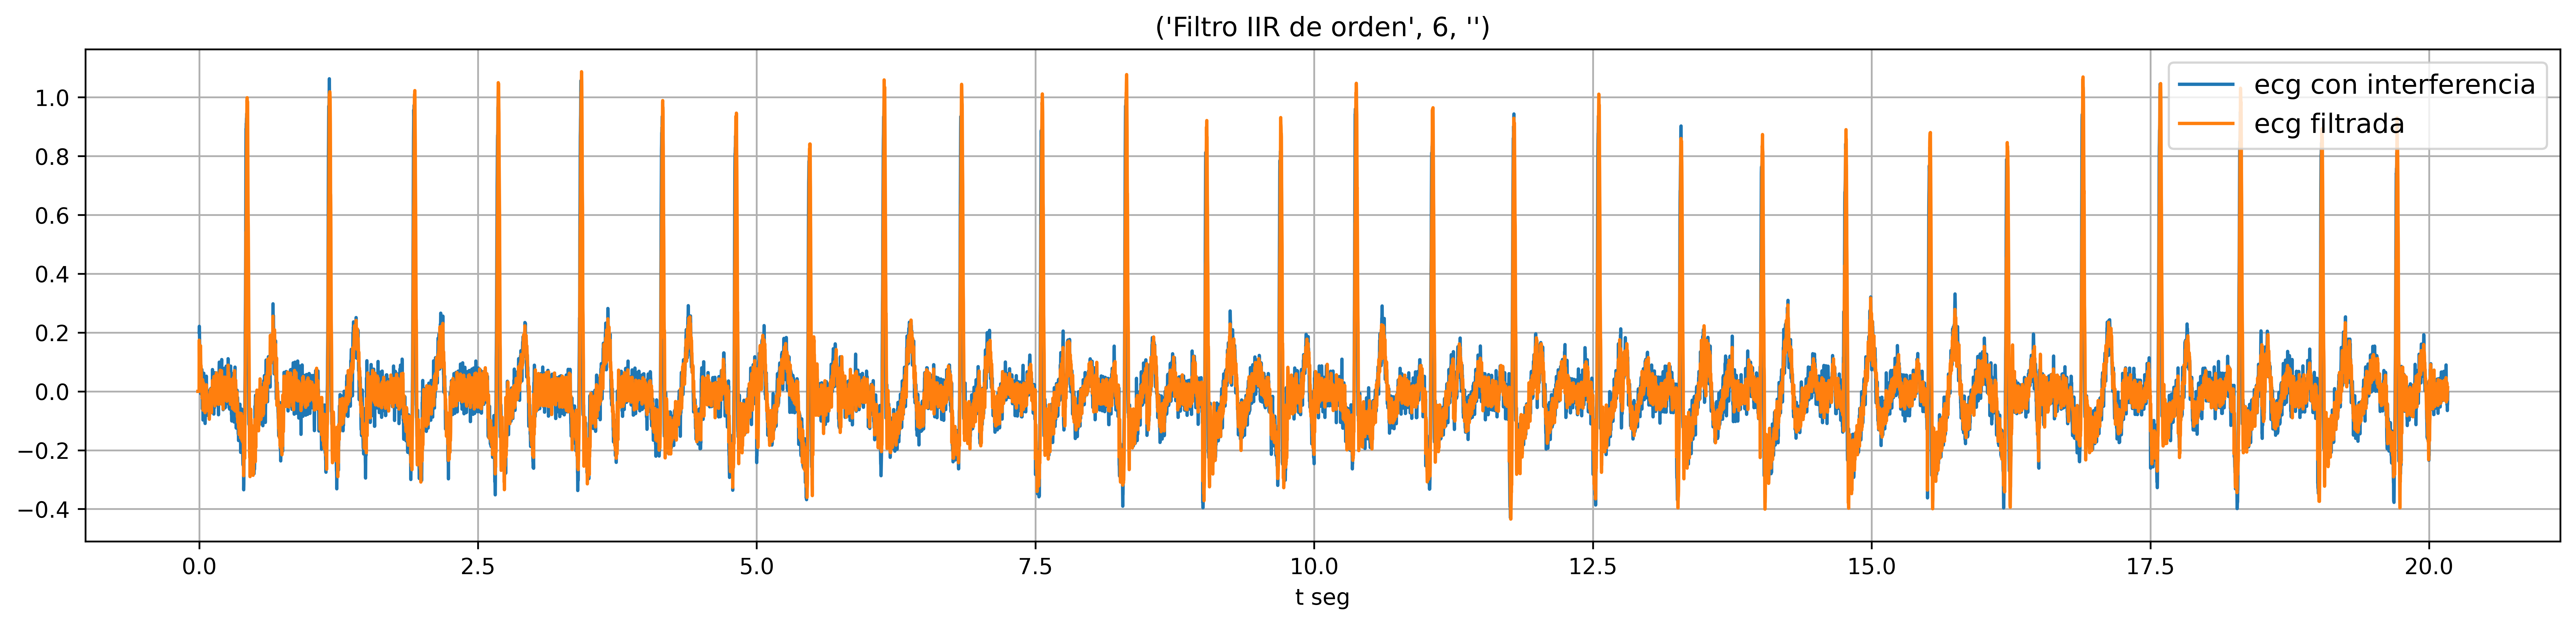

ATENUACION: -1.8
SNR: 1.011004289003376
SNR(dB): 0.21888364733994614
Filtrado finalizado


In [6]:
IIR("/Users/paulaaguirrecarol/Desktop/Copia de 2. ecg_sinf.acq")